# Statistics on the output data. 

### Loading data from the sqlite database to the dataframes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lizard
import subprocess as sub
from pylibsrcml import srcml
import os
import re 
import xml.etree.ElementTree as et 
import warnings
from sqlite3 import connect
from argparse import ArgumentParser
from configparser import ConfigParser
import yaml
from pathlib import Path
import random
from tabulate import tabulate

warnings.filterwarnings("ignore")


database = '../data/IoT.db'
# database = '../data/TinyVul.db'
# database = "/Users/guru/research/TinyVul.db"
conn= connect(database)

random.seed(0)

dfp = pd.read_sql_query("SELECT * FROM project", con=conn)
dfs = pd.read_sql_query("SELECT * FROM statement", con=conn)
dff = pd.read_sql_query("SELECT * FROM function", con=conn)

if not os.path.exists("figure"):
    os.mkdir("figure")
dfs.columns

Index(['file', 'line', 'column', 'defaultlevel', 'level', 'category', 'name',
       'msg', 'note', 'cwe', 'context', 'helpuri', 'severity', 'tool', 'type',
       'project'],
      dtype='object')

### Plotting subburset plot from the frequency of category, name and cwe types. 

In [2]:
dfplt = dfs[['category', 'name', 'cwe']].groupby(['category', 'name', 'cwe'], group_keys=False).size().reset_index(name='count')
fig = px.sunburst(dfplt, 
    path=['category', 'name', 'cwe'], 
    values='count', 
    color_continuous_scale='Blues',
    color='count',
)
# fig.write_image("figure/vul_statistics.pdf")
# fig.update_traces(hovertemplate='%{label}<br>%{customdata}')
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()
# save the figure manually, the below code takes ages
# fig.write_image("../figure/vul_statistics.pdf")

In [3]:
dfplt.sort_values(by=['count'], ascending=False).head(10)

,category,name,cwe,count
3,buffer,char,CWE-119!/CWE-120,46
7,buffer,strlen,CWE-126,19
4,buffer,memcpy,CWE-120,16
5,buffer,sprintf,CWE-120,15
8,buffer,strncpy,CWE-120,14
2,-,unknownMacro,CWE-unknown,5
1,-,returnDanglingLifetime,CWE-562,3
6,buffer,strcpy,CWE-120,2
11,format,snprintf,CWE-134,2
0,-,bufferAccessOutOfBounds,CWE-788,1


# Top 10 vulnerabilities

In [4]:
df_top10 = dfplt.sort_values(by=['count'], ascending=False).head(10).reset_index(drop=True)
print(tabulate(df_top10, headers='keys', tablefmt='psql'))
df_top10.to_latex("../result/top10.tex", index=False, caption="Top 10 CWEs in IoT code")

+----+------------+-------------------------+------------------+---------+
|    | category   | name                    | cwe              |   count |
|----+------------+-------------------------+------------------+---------|
|  0 | buffer     | char                    | CWE-119!/CWE-120 |      46 |
|  1 | buffer     | strlen                  | CWE-126          |      19 |
|  2 | buffer     | memcpy                  | CWE-120          |      16 |
|  3 | buffer     | sprintf                 | CWE-120          |      15 |
|  4 | buffer     | strncpy                 | CWE-120          |      14 |
|  5 | -          | unknownMacro            | CWE-unknown      |       5 |
|  6 | -          | returnDanglingLifetime  | CWE-562          |       3 |
|  7 | buffer     | strcpy                  | CWE-120          |       2 |
|  8 | format     | snprintf                | CWE-134          |       2 |
|  9 | -          | bufferAccessOutOfBounds | CWE-788          |       1 |
+----+------------+------

<AxesSubplot: >

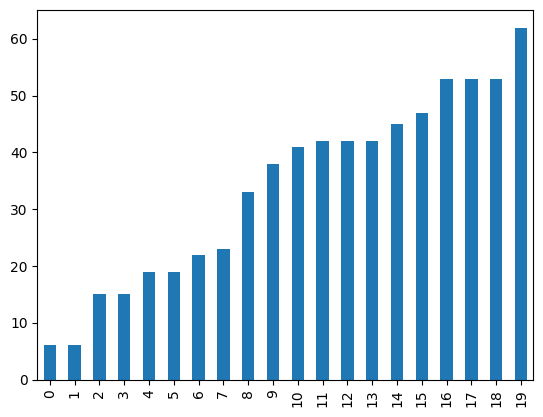

In [5]:
# dfs.context.head(200).str.len().plot(kind='bar')
pd.Series(sorted(list(dfs.context.head(20).str.len()))).plot(kind='bar')

In [6]:
dfs.context

0             char msg_ctxt_id[msgctxt_len + msgid_len];
1                                        char buf[1024];
2        memcpy (msg_ctxt_id, msgctxt, msgctxt_len - 1);
3      memcpy (msg_ctxt_id + msgctxt_len, msgid, msgi...
4             size_t msgctxt_len = strlen (msgctxt) + 1;
                             ...                        
368                                             fd = -1;
369                       strcpy(msg->sendcmd, nextptr);
370                                     char sendcmd[1];
371                       len = strlen((char *)nextptr);
372                                 struct cmd_msg *msg;
Name: context, Length: 373, dtype: object

<AxesSubplot: ylabel='Frequency'>

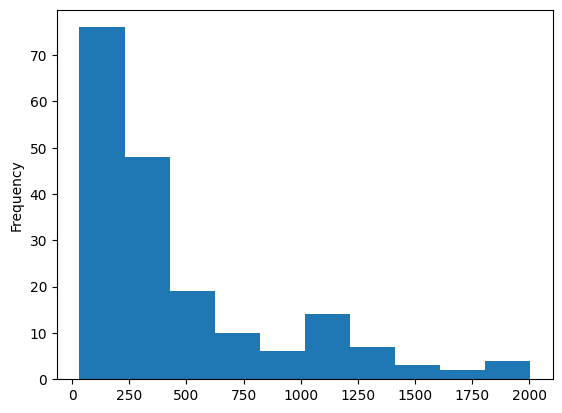

In [7]:
pd.Series([len(x) for x in dff.code if len(x)>10]).plot.hist(xlabel='#chars', ylabel='#statements')

In [8]:
def filter_unusual_statements(statements, min_len, max_len, df):
    """" 
    # https://peps.python.org/pep-0007/
    # https://www.python.org/dev/peps/pep-0007/ 

    """
    filtered_statements = []
    for statement in statements:
        if len(statement) >= min_len and len(statement) <= max_len:
            filtered_statements.append(statement)
   
    # take size of the vul statements as basis
    df = pd.Series(statements)   
    df = df.str.len()
    
    stat_sizes =  list(df[df.between(max_len, min_len)].reset_index(drop=True))
    
    sample_size = 5 if len(stat_sizes)>5 else len(stat_sizes)-1
    stat_sizes = random.sample(set(stat_sizes), sample_size)
    return stat_sizes


# standard variables:
max_len = 79  #TODO: double check pep standards

# TODO: check min_len as well, otherwise the below code unnessesarily checks one extra condition 
# because there is no any statement/fun with len below that. 
# for min_len (eg, 7 characters)
min_len = dfs.context.str.len().sort_values(ascending=False).reset_index(drop=True).min()


lines = dff.code[0].splitlines()
stat_sizes = filter_unusual_statements(lines, max_len, min_len, dfs)
stat_sizes

[17, 27, 33, 70, 18]

In [9]:
# df_dnn = pd.read_csv('../data/iDetect_refine/DNN_Binary.csv')
# df_conti = pd.read_csv('../data/contiki-master_Binary.csv')
# df_rasp = pd.read_csv('../data/raspberry_metrics.csv')
# df_rasp_flaw = pd.read_csv('../data/raspberry_flaw.csv')

# print('Shape of DNN data: ', df_dnn.shape)
# print('Shape of contiki: ', df_conti.shape)
# print('Shape of raspberry: ', df_rasp.shape)
# print('Shape of raspberry flaws: ', df_rasp_flaw.shape)

# dfcon = dfcon.rename(columns={'context': 'code'})
# dfcon.to_csv('../data/contiki-master_Binary.csv', index=False)

# Convert hyperparameters list to latex table format

In [10]:
def hyperpara2latex(yaml_file):
    """
    load the yaml file and return a dictionary
    """
    config = {}
    cols = ['hyperparameter', 'value']
    
    ext = Path(yaml_file).suffix.replace('.', '') 
    
    with open(yaml_file, "r") as stream:
        try:
            config = yaml.safe_load(stream)
            print(type(config))
            df = pd.DataFrame([config['dnn']]).T.reset_index()
            print(df.to_latex(index=False, 
                    header=cols, 
                    #   column_format='|l|l|', 
                    label='Hyperparameter Settings', 
                    caption='Hyperparameter Settings'))
        except yaml.YAMLError as exc:
            print(exc)

config = hyperpara2latex('../config.yaml')

<class 'dict'>
\begin{table}
\centering
\caption{Hyperparameter Settings}
\label{Hyperparameter Settings}
\begin{tabular}{ll}
\toprule
hyperparameter &                           value \\
\midrule
        epochs &                              50 \\
  debug\_epochs &                               3 \\
         batch &                             128 \\
  input\_length &                             150 \\
     input\_dim &                             150 \\
    output\_dim &                              32 \\
            lr &                            1e-4 \\
      patience &                             100 \\
     optimizer &                            adam \\
        l2\_reg &                            1e-4 \\
       dropout &                             0.0 \\
 recur\_dropout &                             0.0 \\
        beta\_1 &                             0.9 \\
        beta\_2 &                           0.999 \\
       epsilon &                           1e-08 \\
         decay &

## Frequency of the vulnerabilities and benign samples at 
    - statement-level 
    - function-level

In [11]:
# for project-wise distribution
projects = list(dfs.project.unique())

for project in projects:
    print(project)
    df = dfs[dfs.project == project]
    print(df.shape)
    print(df.cwe.value_counts())
    print(df.category.value_counts())
    print('----------------------')

/Users/guru/research/projects/gnucobol-3.2/lib/
(27, 16)
Benign              18
CWE-562              3
CWE-119!/CWE-120     2
CWE-120              2
CWE-126              2
Name: cwe, dtype: int64
buffer    6
-         3
Name: category, dtype: int64
----------------------
data/projects/contiki-2.4/apps/shell/
(346, 16)
Benign              230
CWE-120              45
CWE-119!/CWE-120     44
CWE-126              17
CWE-unknown           6
CWE-134               3
CWE-788               1
Name: cwe, dtype: int64
buffer                      106
-                             6
format                        3
fixed size global buffer      1
Name: category, dtype: int64
----------------------


## Create a latex table from the statistics of projects

In [12]:
def save_latex(df, file):
    """
    save the dataframe as latex table
    """
    styler = df.style
    # styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
    styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
    res = styler.to_latex(convert_css=True, column_format='|l|l|r|')

    with open(file, 'w') as f:
        f.write(res)
    return res

# make class binary type benign/vulnerable
dfs_binary = dfs.copy()
dfs_binary.loc[dfs_binary.cwe!="Benign", 'cwe'] = "Vulnerable"
dfs_binary['project'] = dfs_binary.project.str.split('/').str[-1]

prj_stat = dfs_binary.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_s = prj_stat.groupby(['project', 'cwe']).sum()

res = tabulate(save_latex(prj_s, '../result/project_stat.tex'))
prj_s

count
project cwe              
        Benign        248
        Vulnerable    125

In [13]:
prj_sflat = prj_s.reset_index()
prj_sflat = prj_sflat.pivot(index='project', columns='cwe', values='count')
prj_sflat.reset_index().to_latex('../result/project_stat_flat.tex', index=False)

In [14]:
# make class binary type benign/vulnerable
dff_binary = dff.copy()
dff_binary.loc[dff_binary.cwe!="Benign", 'cwe'] = "Vulnerable"

prj_ff = dff_binary.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_f = prj_ff.groupby(['cwe']).sum().sort_values(by='count', ascending=False).reset_index()
prj_f = prj_f[prj_f.cwe != 'Benign'].head(10)
print(prj_f.to_latex(index=False, caption='Top 10 CWEs', label='Top 10 CWEs'))

\begin{table}
\centering
\caption{Top 10 CWEs}
\label{Top 10 CWEs}
\begin{tabular}{lr}
\toprule
       cwe &  count \\
\midrule
Vulnerable &     45 \\
\bottomrule
\end{tabular}
\end{table}



In [15]:
prj_s = dfs.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_s = prj_s.groupby(['cwe']).sum()
prj_s

,count
cwe,
Benign,248
CWE-119!/CWE-120,46
CWE-120,47
CWE-126,19
CWE-134,3
CWE-562,3
CWE-788,1
CWE-unknown,6


# Show the description of the function-level data

In [16]:
df_describe = dff_binary.drop(
    labels=['top_nesting_level', 'fan_in', 'fan_out', 'general_fan_out', 'content', 'long_name', 'fun_name', 'full_parameters', 'code'],
    axis=1, 
    errors='ignore').describe().T

df_freq = df_describe.reset_index().rename(columns={'index': 'features'})
df_freq = df_freq.drop(labels=['count'], axis=1)
# The freq is the most common value’s frequency. The top is the most common value.

print(df_freq[~df_freq.features.isin(['file'])].to_latex(
    index=False, 
    column_format='rrrrr', 
    label='Function Statistics', 
    caption='Function Statistics')
    )

\begin{table}
\centering
\caption{Function Statistics}
\label{Function Statistics}
\begin{tabular}{rrrrr}
\toprule
features & unique &                                   top & freq \\
\midrule
 context &     34 &                                       &  144 \\
     cwe &      2 &                                Benign &  144 \\
 project &      2 & data/projects/contiki-2.4/apps/shell/ &  171 \\
\bottomrule
\end{tabular}
\end{table}



In [17]:
dfs.cwe.value_counts()

Benign              248
CWE-120              47
CWE-119!/CWE-120     46
CWE-126              19
CWE-unknown           6
CWE-562               3
CWE-134               3
CWE-788               1
Name: cwe, dtype: int64

In [18]:
dff.cwe.value_counts()

Benign         144
CWE-unknown     45
Name: cwe, dtype: int64

In [19]:
print(f'Size of statements: {len(dfs.context)}')
print(f'Size of unique statements: {dfs.context.nunique()}')

print(f'\nSize of functions: {len(dff.code)}')
print(f'Size of unique functions: {dff.code.nunique()}')

Size of statements: 373
Size of unique statements: 357

Size of functions: 189
Size of unique functions: 146


In [20]:
dff[dff.cwe=='Benign'].drop_duplicates().reset_index(drop=True)

,file,code,context,cwe,project
0,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,,Benign,/Users/guru/research/projects/gnucobol-3.2/lib/
1,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,,Benign,/Users/guru/research/projects/gnucobol-3.2/lib/
2,data/projects/contiki-2.4/apps/shell/shell-file.c,void\nshell_file_init(void)\n{\n shell_regist...,,Benign,data/projects/contiki-2.4/apps/shell/
3,data/projects/contiki-2.4/apps/shell/shell-rsh.c,static void\nconnected_meshconn(struct meshcon...,,Benign,data/projects/contiki-2.4/apps/shell/
4,data/projects/contiki-2.4/apps/shell/shell-rsh.c,static void\nrecv_meshconn(struct meshconn_con...,,Benign,data/projects/contiki-2.4/apps/shell/
...,...,...,...,...,...
139,data/projects/contiki-2.4/apps/shell/shell-dow...,static void\nrequest_sent(struct runicast_conn...,,Benign,data/projects/contiki-2.4/apps/shell/
140,data/projects/contiki-2.4/apps/shell/shell-dow...,static void\nrequest_timedout(struct runicast_...,,Benign,data/projects/contiki-2.4/apps/shell/
141,data/projects/contiki-2.4/apps/shell/shell-dow...,void\nshell_download_init(void)\n{\n req_seq_...,,Benign,data/projects/contiki-2.4/apps/shell/
142,data/projects/contiki-2.4/apps/shell/shell-rim...,"static void\nrecv_uc(struct unicast_conn *c, c...",,Benign,data/projects/contiki-2.4/apps/shell/


In [21]:
print(len(dff[dff.cwe!='Benign'].reset_index(drop=True)))
dff[dff.cwe!='Benign'].drop_duplicates().reset_index(drop=True).head(5)

45


,file,code,context,cwe,project
0,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,return translation;,CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/
1,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,return translation;,CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/
2,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,char msg_ctxt_id[msgctxt_len + msgid_len];,CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/
3,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,char buf[1024];,CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/
4,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,"memcpy (msg_ctxt_id, msgctxt, msgctxt_len - 1);",CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/


In [22]:
# dff_new = dff.drop_duplicates().reset_index(drop=True)
dff.loc[dff.astype(str).drop_duplicates().index].reset_index(drop=True)

,file,code,context,cwe,project
0,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,,Benign,/Users/guru/research/projects/gnucobol-3.2/lib/
1,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,return translation;,CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/
2,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,,Benign,/Users/guru/research/projects/gnucobol-3.2/lib/
3,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,return translation;,CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/
4,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,char msg_ctxt_id[msgctxt_len + msgid_len];,CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/
...,...,...,...,...,...
184,data/projects/contiki-2.4/apps/shell/shell-dow...,static void\nrequest_sent(struct runicast_conn...,,Benign,data/projects/contiki-2.4/apps/shell/
185,data/projects/contiki-2.4/apps/shell/shell-dow...,static void\nrequest_timedout(struct runicast_...,,Benign,data/projects/contiki-2.4/apps/shell/
186,data/projects/contiki-2.4/apps/shell/shell-dow...,void\nshell_download_init(void)\n{\n req_seq_...,,Benign,data/projects/contiki-2.4/apps/shell/
187,data/projects/contiki-2.4/apps/shell/shell-rim...,"static void\nrecv_uc(struct unicast_conn *c, c...",,Benign,data/projects/contiki-2.4/apps/shell/


In [151]:
def filter_benign(code_dup, cwe):
    """ masking to filter duplicates and benign 
    keeping vulnerable samples as it is.
    """
    if code_dup == True and cwe == 'Benign':
        return True
    else:
        return False


def filter_dulicates_and_ambiquius(df):
    """ apply filtering to remove duplicates and ambiquious samples
    """
    print('='*40)
    print('Removing duplicates and ambiquious samples...')
    print('-'*40)
    df = df.sort_values(by=['code','cwe'], ascending=False)
    original_size = len(df)
    print(f'Original data size before filtering: {len(df)}')

    ## step1: remove duplicates checking ['code', 'cwe']
    df = df.drop_duplicates(subset=['code', 'cwe']).reset_index(drop=True)
    step1_size = len(df)
    print(f"Step1-filtering on [code and cwe]: {len(df)} [filtered {original_size-step1_size}]")

    ## step2: remove duplicates checking ['code']
    df['code_dup'] = df['code'].duplicated()
    # df = df[~df['code_dup']] # this removes vul samples as well
    df['filter_mask'] = df.apply(lambda row: filter_benign(row.code_dup, row.cwe), axis=1)
    df = df[~df['filter_mask']].reset_index(drop=True)
    df = df.drop(labels=['code_dup', 'filter_mask'], axis=1)
    step2_size = len(df)
    print(f"Step2-filtering on [code] with vuls: {len(df)} [filtered {step1_size-step2_size}]")
    print('='*40)
    return df

df = filter_dulicates_and_ambiquius(dff)

Removing duplicates and ambiquious samples...
----------------------------------------
Original data size before filtering: 189
Step1-filtering on [code and cwe]: 163 [filtered 26]
Step2-filtering on [code] with vuls: 146 [filtered 17]


In [137]:
df.cwe.value_counts()

Benign         127
CWE-unknown     19
Name: cwe, dtype: int64

In [138]:
dff.cwe.value_counts()

Benign         144
CWE-unknown     45
Name: cwe, dtype: int64

In [74]:
dff_sort.drop(dff_sort[dff_sort.filter_mask].index).reset_index(drop=True)

,file,code,context,cwe,project,code_dup,verdict,filter,filter_mask
0,data/projects/contiki-2.4/apps/shell/shell-htt...,void\nwebserver_log_file(uip_ipaddr_t *request...,char buf[48];,CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,True,False,False
1,data/projects/contiki-2.4/apps/shell/shell-htt...,void\nwebserver_log(char *msg)\n{\n shell_out...,,Benign,data/projects/contiki-2.4/apps/shell/,False,False,True,False
2,data/projects/contiki-2.4/apps/shell/shell-wget.c,void\nwebclient_timedout(void)\n{\n shell_out...,,Benign,data/projects/contiki-2.4/apps/shell/,False,False,True,False
3,data/projects/contiki-2.4/apps/shell/shell-wget.c,"void\nwebclient_datahandler(char *data, u16_t ...",,Benign,data/projects/contiki-2.4/apps/shell/,False,False,True,False
4,data/projects/contiki-2.4/apps/shell/shell-wget.c,void\nwebclient_connected(void)\n{\n shell_ou...,,Benign,data/projects/contiki-2.4/apps/shell/,False,False,True,False
...,...,...,...,...,...,...,...,...,...
141,data/projects/contiki-2.4/apps/shell/shell.c,"int\nshell_start_command(char *commandline, in...",,Benign,data/projects/contiki-2.4/apps/shell/,False,False,True,False
142,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,return translation;,CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/,False,True,False,False
143,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,return translation;,CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/,False,True,False,False
144,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,char msg_ctxt_id[msgctxt_len + msgid_len];,CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/,False,True,False,False


In [28]:
dff_sort.sort_values(by=['code', 'cwe']).cwe.value_counts()

Benign         144
CWE-unknown     19
Name: cwe, dtype: int64

In [78]:
dff_new = dff_sort.copy()
dff_new = dff_new.sort_values(by=['code', 'cwe'], ascending=True)
# this code remove the duplicates and keep the last, ignores 'Benign' samples
df_dup = dff_new[dff_new.duplicated(['code'], keep='first')].reset_index(drop=True)
df_dup
# dff_new

,file,code,context,cwe,project,code_dup,verdict,filter,filter_mask
0,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,return translation;,CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/,False,True,False,False
1,/Users/guru/research/projects/gnucobol-3.2/lib...,__inline\n#else\n#ifdef __cplusplus\ninline\n#...,return translation;,CWE-unknown,/Users/guru/research/projects/gnucobol-3.2/lib/,False,True,False,False
2,data/projects/contiki-2.4/apps/shell/shell.c,static struct shell_command *\nstart_command(c...,command_len = (int)strlen(commandline);,CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,True,False,False
3,data/projects/contiki-2.4/apps/shell/shell-net...,"static void\nmemcpy_misaligned(void *dest, con...","memcpy(dest, source, len);",CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,True,False,False
4,data/projects/contiki-2.4/apps/shell/shell-wget.c,static void\nopen_url(char *url)\n{\n unsigne...,static char host[32];,CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,True,False,False
5,data/projects/contiki-2.4/apps/shell/shell-pow...,static void\nprintpower(struct power_msg *msg)...,char buf[100];,CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,True,False,False
6,data/projects/contiki-2.4/apps/shell/shell-pow...,static void\nprintpowergraph(struct power_msg ...,char buf[MAX_POWERGRAPH];,CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,True,False,False
7,data/projects/contiki-2.4/apps/shell/shell-rime.c,static void\nrecv_collect(const rimeaddr_t *or...,char buf[40];,CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,True,False,False
8,data/projects/contiki-2.4/apps/shell/shell-rim...,"static void\nrecv_mesh(struct mesh_conn *c, co...",char buf[64];,CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,True,False,False
9,data/projects/contiki-2.4/apps/shell/shell-rim...,"static void\nrecv_uc(struct unicast_conn *c, c...","memcpy(output_blob.data, msg->data, packetbuf_...",CWE-unknown,data/projects/contiki-2.4/apps/shell/,False,True,False,False


In [158]:
# table-wise columns to check duplicates

code_col = 'code' if 'code' in df.columns else 'context'
code_col

'code'